# PROJECT TITLE: APPLICANT DEFAULT PREDICTION

## Problem Statement

*In the dynamic landscape of finance and lending, the accurate prediction of loan defaults is paramount for effective risk management and decision-making by financial institutions. Traditional methods are often limited, prompting the need for advanced machine learning models. The challenge lies in developing a robust predictive model capable of automatically identifying potential loan defaulters, thereby enabling lenders to proactively manage risks, minimize financial losses, and make well-informed lending decisions. The project aims to address this crucial need by leveraging historical loan data and implementing sophisticated machine learning algorithms to create accurate predictive models for assessing the likelihood of borrower default.*

### Importing libraries

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from scipy import stats


from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import json
import itertools


## Data Collection

In [3]:
df = pd.read_csv('train.csv')

In [4]:
# defining identifiers to be used throughout the project for the homogeneity
approved="Approved"
not_approved="Not Approved"

In [5]:
# replace some data with meaningfull words
df['Loan_Status'].replace({"Y":approved,"N":not_approved},inplace=True)
df['Credit_History'].replace({1.0:'Have Credit History',0.0:"No Credit History"},inplace=True)
df['Married'].replace({"No":'Not Married','Yes':"Married"},inplace=True)
df['Self_Employed'].replace({"No":'Not Self Employed','Yes':"Self Employed"},inplace=True)


In [6]:
# initializing dict to store data
loanApproval_dict_data = dict()

## Data Archeology (Data Profiling)

Examining, analyzing, reviewing and summarizing data sets to gain insight into the quality of data is going to be proceeded


***Checking the missing values***

In [7]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

INTERPRETATION:
* Almost the features possess missing values which has to be addressed

***Data type checking***

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    object 
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


INTERPRETATION:
* The data illustrates that almost the features are categorical expect applicant income, coapplicant income, loan amount, and loan amount term.

###### Highly frequent loan term

In [9]:
df.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

***Categorical data investigation***

In [10]:
df.nunique() / len(df)

Loan_ID              1.000000
Gender               0.003257
Married              0.003257
Dependents           0.006515
Education            0.003257
Self_Employed        0.003257
ApplicantIncome      0.822476
CoapplicantIncome    0.467427
LoanAmount           0.330619
Loan_Amount_Term     0.016287
Credit_History       0.003257
Property_Area        0.004886
Loan_Status          0.003257
dtype: float64

INTERPRETATION:
* From the categorical data investigation; loan_id, ApplicantIncome, coapplicantIncome, loanAmount are non-categorical data because of high percentage of non repeating numbers whereas other have low percentage of repeating values, therefore are categorical values.

***Missing values checking***

In [11]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

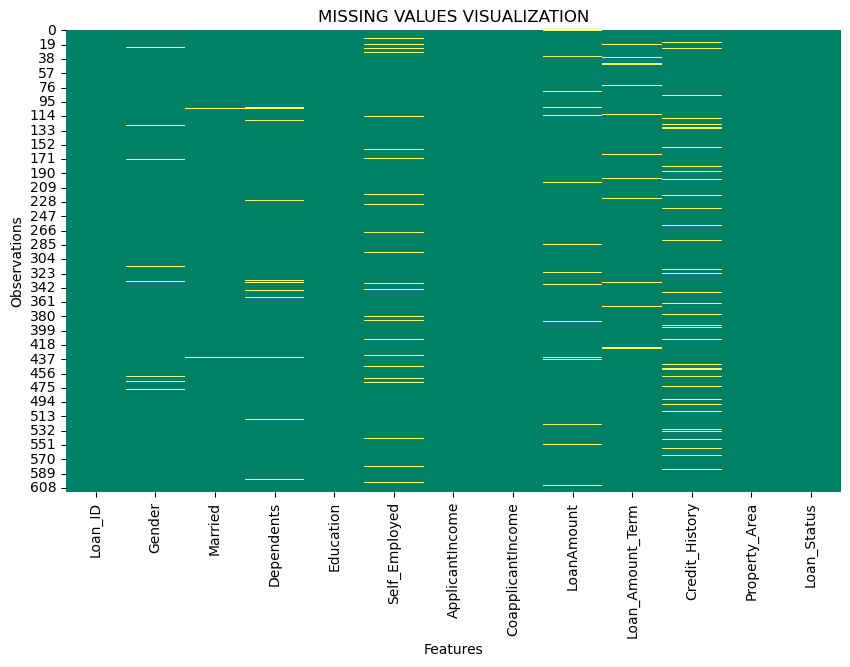

In [12]:
# visualize the missing values again
plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar = False, cmap="summer")
plt.title("MISSING VALUES VISUALIZATION")
plt.ylabel("Observations")
plt.xlabel("Features")
plt.show()

INTERPRETATION: 
* Missing values are distributed amoung almost the features except loan_id, education, applicant income, coapplicant income, property area and loan_status features.

***Row Duplicate checking***

In [13]:
df.duplicated().sum()

0

There is no duplicate observation in the dataset

## Data Cleaning

#### Addressing missing values

In [14]:
column_name = df.columns
for feature in column_name:
  if df[feature].dtype == "O":
    df[feature].fillna(df[feature].mode()[0], inplace=True)
  else:
    df[feature].fillna(df[feature].median(), inplace=True)

**INTERPRATION:**
* All the missing object (categorical) data type have been be filled with the most frequent values
* All the missing non-object data type have been filled with the median

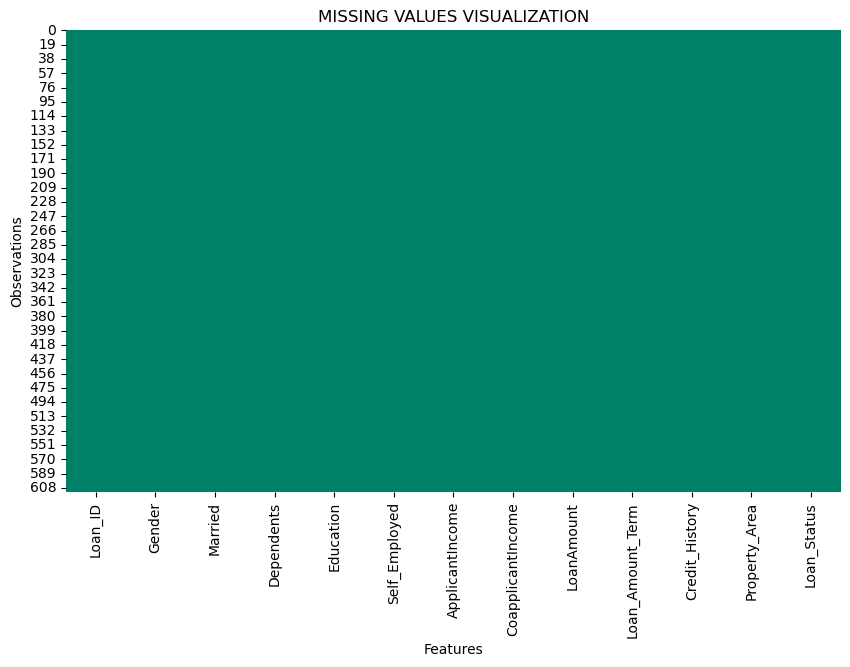

In [15]:
# visualize the missing values again
plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar = False, cmap="summer")
plt.title("MISSING VALUES VISUALIZATION")
plt.ylabel("Observations")
plt.xlabel("Features")
plt.show()

**INTERPRETATION:** 
- The dataset is clean and ready to be explored

## Exploratory Analysis (EDA)

### Univariate Analysis

Univariate analysis is a statistical method that involves the examination and interpretation of a single variable in isolation. In this type of analysis, the focus is solely on understanding the distribution, central tendency, and characteristics of one variable at a time. Univariate analysis is particularly useful for gaining insights into the basic properties of individual variables without considering their relationships with other variables.

#### 1. Descriptive Statistics

Calculating measures such as mean, median, mode, range, and standard deviation to summarize the main features of the variable. This technique is applied to continous data only.

In [16]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423
std,6109.041673,2926.248369,84.107233,64.428629
min,150.000000,0.000000,9.000000,12.000000
25%,2877.500000,0.000000,100.250000,360.000000
50%,3812.500000,1188.500000,128.000000,360.000000
75%,5795.000000,2297.250000,164.750000,360.000000
max,81000.000000,41667.000000,700.000000,480.000000


**INTERPRETATION:**
    
Income Distribution:
        
- The 'ApplicantIncome' ranges from a minimum of 150 to a maximum of 81,000, indicating a diverse distribution.
- 'CoapplicantIncome' also varies widely, with a range from 0 to 41,667.

Loan Amounts:
- 'LoanAmount' varies from 9 to 700, suggesting a considerable range in loan amounts requested.

Loan Term:
- 'Loan_Amount_Term' has a mean of 342, with a minimum of 12 and a maximum of 480, indicating varying loan terms.

Credit History:
- 'Credit_History' is mostly positive (1.0) as indicated by the mean of 0.84, with a minimum of 0 and a maximum of 1.

Income Quartiles:
- The first quartile (25%) of 'ApplicantIncome' is 2877.5, the median is 3812.5, and the third quartile (75%) is 5795.0.

Loan Amount Quartiles:
- The first quartile of 'LoanAmount' is 100, the median is 128, and the third quartile is 168.

These insights provide a preliminary understanding of the distribution and central tendencies of key variables. Further analysis and exploration could reveal relationships between these variables and assist in making informed decisions, especially in the context of loan approval and risk assessment.

**2. Frequency Distribution**

In this technique, chart that displays the frequency of each value or range of values in some variable will be implemented.

**Loan Status**

In [17]:
# doing calculation
loanStatus = df['Loan_Status'].value_counts().astype(int) # change the int type to make it able to be transformed to json file.
loanStatus.index = [approved,not_approved]
loanStatus_dict = loanStatus.to_dict()
# store in the main dict data
loanApproval_dict_data['Loan Status'] = loanStatus_dict

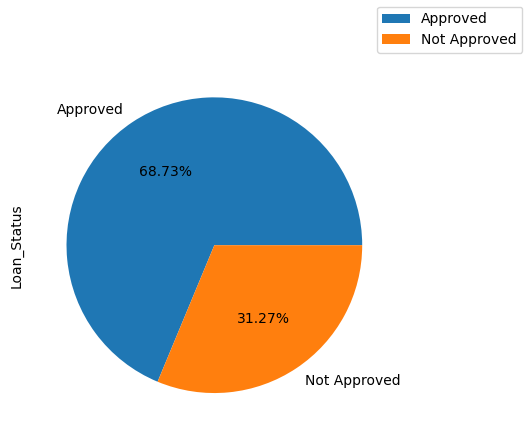

In [18]:
# plot the pie chart
df['Loan_Status'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.figlegend([approved,not_approved])
plt.show()

**Marital Status**

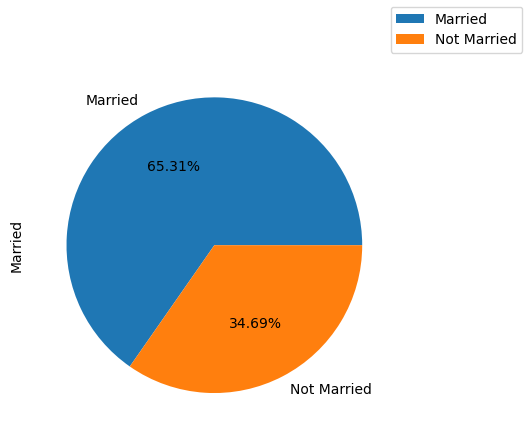

In [19]:
df['Married'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.figlegend(["Married","Not Married"])
plt.show()

**3. Histogram and Probability Density Functions (PDF)**

Visual representations that provide a graphical view of the distribution and central tendency of the variable.
Also Probability Density Functions (PDF) is a mathematical function that describes the likelihood of different outcomes in a continuous variable.

**defining a function to find histogram**

In [20]:
# define a function signature
def findDistribution(df,feature_name):
  bins = 15

  mask = df[feature_name].notna()

  data = df[mask][feature_name]

  # getting the information (count and bins_count) on data by using the histogram method from numpy library
  count,bins_count = np.histogram(data, bins=bins)


  # plot "count" against "bins_count[1:]" and give a color of red with a label argument named "pdf"
  plt.plot(bins_count[1:],count)

  # plot the histogram by using "hist" method of pandas library again for better seeing the distribution
  (df[feature_name]).hist(bins=bins)

  # give the graph the title
  plt.title(feature_name)

  # label x axis
  plt.xlabel(feature_name)

  # label y axis
  plt.ylabel("Applicants Number")
  return [count, bins_count[1:]]

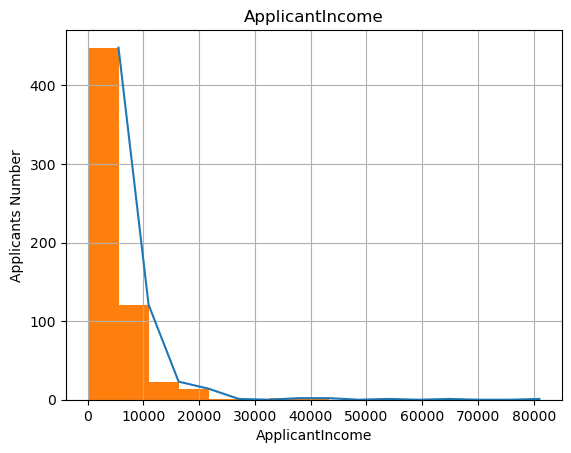

In [21]:
[Applicants,ApplicantIncome] = findDistribution(df,'ApplicantIncome')

In [22]:
# Storing the histogram data
hist_dict=dict()
hist_dict['Applicants'] = [int(x) for x in Applicants]
hist_dict['Applicant Income'] = [int(x) for x in ApplicantIncome] 
loanApproval_dict_data['Applicant Income Histogram'] = hist_dict

**4. Box plot**

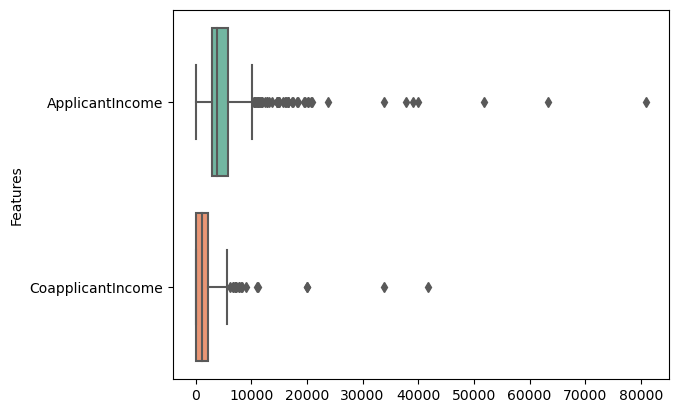

In [23]:
sns.boxplot(data=df[['ApplicantIncome','CoapplicantIncome']],orient='h',palette='Set2')
plt.ylabel("Features")
plt.show()

INTERPRATATION:
- The box plot shows us that almost of the appplicant income have income less than approximately 12,000 and possess few exceptional applicants with high income.

- In addition, it shows that in the coapplicant income most of the them have the income less than 7500.

## Bivariate Analysis

Bivariate analysis is a statistical analysis method that involves the simultaneous examination of two variables to understand the relationships between them. Unlike univariate analysis, which focuses on the characteristics of a single variable, bivariate analysis explores how two variables interact, correlate, or depend on each other.
In this analysis all the features will be analysed with target variable which is "loan status"

**1. Correlation Analysis**

In [24]:
encoder = LabelEncoder()

In [25]:
for col in df.select_dtypes(include=['object']).columns:
    df[col+'_encoded'] = encoder.fit_transform(df[col])

**re-encode some feature by meaningfully assigning the weight that make sense**

In [26]:
# Create an OrdinalEncoder instance with specified categories
ordinal_encoder_education = OrdinalEncoder(categories=[['Not Graduate', 'Graduate']])
ordinal_encoder_history = OrdinalEncoder(categories=[['No Credit History', 'Have Credit History']])
ordinal_encoder_status = OrdinalEncoder(categories=[['Not Approved', 'Approved']])


In [27]:
# Fit and transform the data and overwrites the not diserable encoding
df['Education_encoded'] = ordinal_encoder_education.fit_transform(df[['Education']])
df['Credit_History_encoded'] = ordinal_encoder_history.fit_transform(df[['Credit_History']])
df['Loan_Status_encoded'] = ordinal_encoder_status.fit_transform(df[['Loan_Status']])

In [28]:
corr_matrix = df.drop(['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status','Credit_History'],axis=1).corr().round(2)[['Loan_Status_encoded']][:-1]

In [29]:
corr_matrix.index = ['Applicant Income', 'Coapplicant Income', 'Loan Amount',
       'Loan Amount Term', 'Loan ID', 'Gender',
       'Married', 'Dependents', 'Education',
       'Self Employed', 'Credit History',
       'Property Area']
corr_matrix.columns = ["Loan Status"]

In [30]:
loanApproval_dict_data['Correlation With Loan Status'] = corr_matrix.T.astype(int).to_dict()

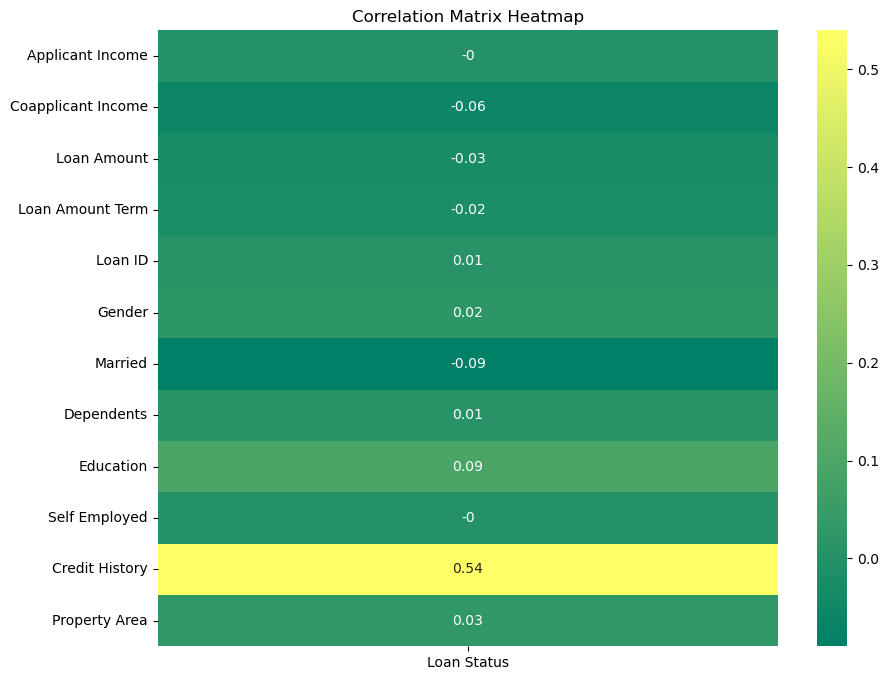

In [31]:
## plot corr matrix into heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap='summer')
plt.title('Correlation Matrix Heatmap');

In [32]:
corr_matrix.to_dict()

{'Loan Status': {'Applicant Income': -0.0,
  'Coapplicant Income': -0.06,
  'Loan Amount': -0.03,
  'Loan Amount Term': -0.02,
  'Loan ID': 0.01,
  'Gender': 0.02,
  'Married': -0.09,
  'Dependents': 0.01,
  'Education': 0.09,
  'Self Employed': -0.0,
  'Credit History': 0.54,
  'Property Area': 0.03}}

INTERPRETATION:
The correlation results indicate the strength and direction of the linear relationship between each feature and the "Loan Status" in the dataset. The correlation coefficient ranges from -1 to 1, where:

   * A value of 1 indicates a perfect positive correlation (as one variable increases, the other also increases).
   * A value of -1 indicates a perfect negative correlation (as one variable increases, the other decreases).
   * A value of 0 indicates no correlation.

Interpretation of the correlation results:

   * Applicant Income (-0.0): There is a very weak or negligible correlation between Applicant Income and Loan Status.

   * Coapplicant Income (-0.06): There is a weak negative correlation between Coapplicant Income and Loan Status, suggesting a slight tendency for lower coapplicant income to be associated with a higher likelihood of loan approval.

   * Loan Amount (-0.03): There is a weak negative correlation between Loan Amount and Loan Status, implying a slight tendency for lower loan amounts to be associated with a higher likelihood of loan approval.

   * Loan Amount Term (-0.02): There is a very weak negative correlation between Loan Amount Term and Loan Status.

   * Loan ID (0.01): There is virtually no correlation between Loan ID and Loan Status.

   * Gender (0.02): There is a very weak positive correlation between Gender and Loan Status.

   * Married (-0.09): There is a weak negative correlation between the marital status (Married) and Loan Status, suggesting that unmarried individuals might have a slightly higher likelihood of loan approval.

   * Dependents (0.01): There is virtually no correlation between the number of dependents and Loan Status.

   * Education (0.09): There is a weak positive correlation between Education and Loan Status, indicating that individuals with higher education levels might have a slightly higher likelihood of loan approval.

   * Self Employed (-0.0): There is virtually no correlation between self-employment status and Loan Status.

   * Credit History (0.54): There is a moderate positive correlation between Credit History and Loan Status, suggesting that a positive credit history significantly increases the likelihood of loan approval.

   * Property Area (0.03): There is a weak positive correlation between Property Area and Loan Status.

In summary, correlation analysis shows that features like Credit History, Education, and Marital Status show notable correlations with Loan Status, providing valuable insights into factors that might influence loan approval decisions.

**2. Crosstabulation (Contingency Tables)**

In [33]:
# initializing dictionary for storing data related to bar chart
barChart_Data=dict()

In [34]:
def bivariate_analysis(feature,title):
    feature_vs_target = pd.crosstab(df[feature],df['Loan_Status'],values=df['Loan_Status'],aggfunc='count')
    barChart_Data[title] = feature_vs_target.astype(int).T.to_dict()
    feature_vs_target.plot(kind='bar',legend=False)
    plt.ylabel('Applicants')
    plt.title(title)
    plt.xticks(rotation=25);
    plt.figlegend()
    return feature_vs_target

**a. Property Area Influences Loan Approval**

Loan_Status,Approved,Not Approved
Property_Area,,
Rural,110,69
Semiurban,179,54
Urban,133,69


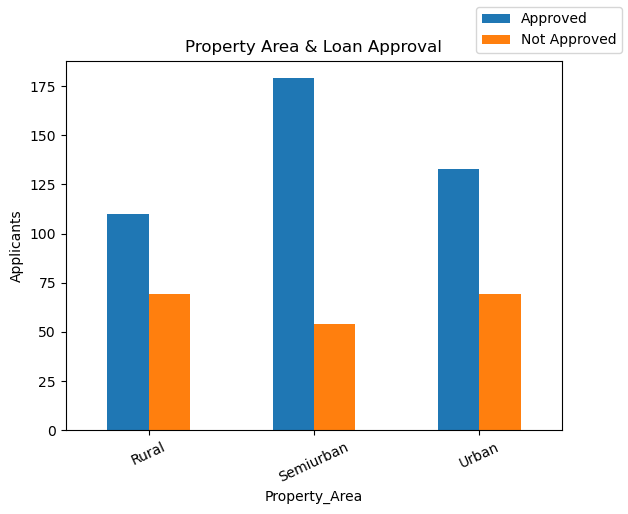

In [35]:
bivariate_analysis('Property_Area', "Property Area & Loan Approval")

**b. Loan Status Based on marital status**

Loan_Status,Approved,Not Approved
Married,,
Married,288,113
Not Married,134,79


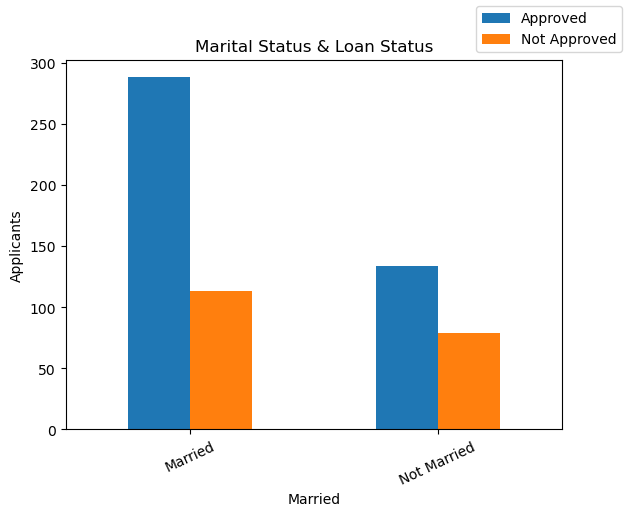

In [36]:
bivariate_analysis('Married', "Marital Status & Loan Status")

**c. Gender-dependent loan status**

Loan_Status,Approved,Not Approved
Gender,,
Female,75,37
Male,347,155


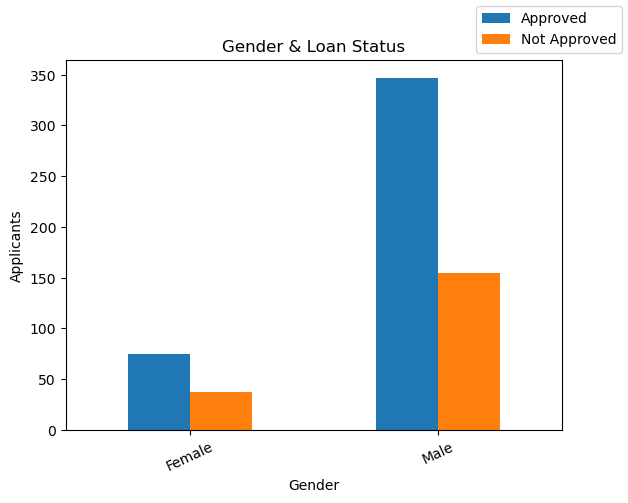

In [37]:
bivariate_analysis('Gender', "Gender & Loan Status")

**d. Applicant education and loan approval status**

Loan_Status,Approved,Not Approved
Education,,
Graduate,340,140
Not Graduate,82,52


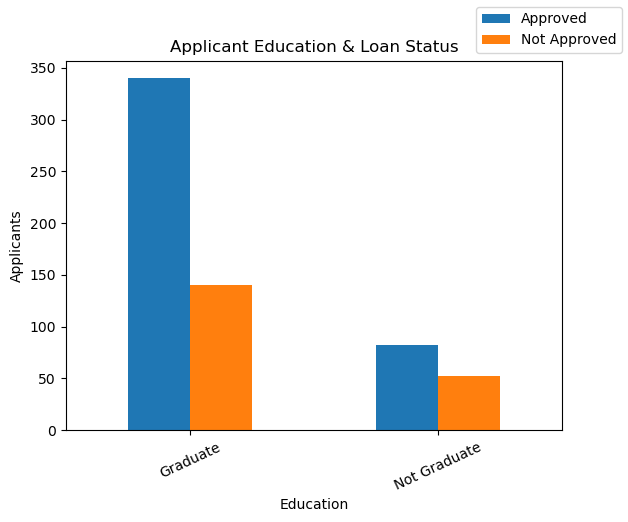

In [38]:
bivariate_analysis('Education', "Applicant Education & Loan Status")

**e. Loan approval based on employment status**

Loan_Status,Approved,Not Approved
Self_Employed,,
Not Self Employed,366,166
Self Employed,56,26


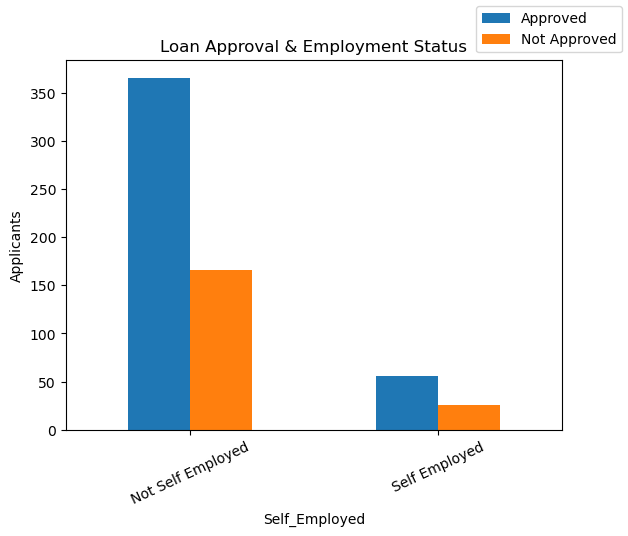

In [39]:
bivariate_analysis('Self_Employed', "Loan Approval & Employment Status")

**f. Loan Approval based on Credit History**

Loan_Status,Approved,Not Approved
Credit_History,,
Have Credit History,415,110
No Credit History,7,82


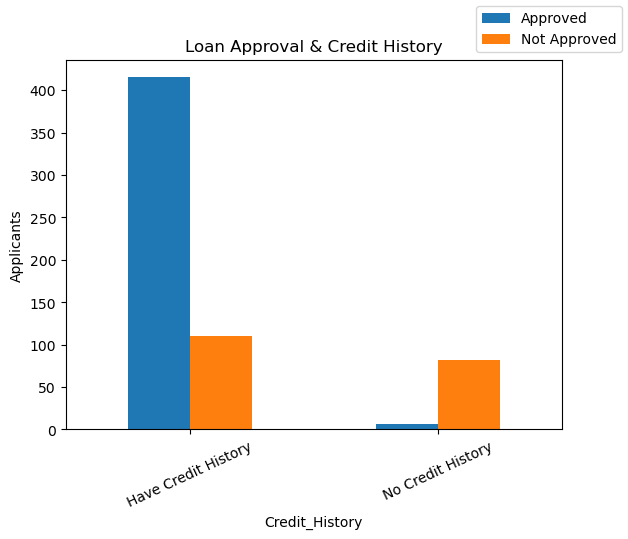

In [40]:
bivariate_analysis('Credit_History', "Loan Approval & Credit History")

#### Storing the barchart data in the main dict

In [41]:
loanApproval_dict_data['barChart_Data'] = barChart_Data

**Selecting DataFrame to be stored in a json**

In [42]:
# select
df_data = df[['Loan_ID','Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']]

In [43]:
# rename columns
df_data.columns = ['Loan ID','Gender', 'Married', 'Dependents', 'Education', 'Self Employed',
       'Applicant Income', 'Coapplicant Income', 'Loan Amount',
       'Loan Amount Term', 'Credit History', 'Property Area', 'Loan Status']

In [44]:
df_data['Applicant Income'] = df_data['Applicant Income'].astype(int)

In [45]:
df_data = df_data.astype(object)

In [46]:
loanApproval_dict_data['data'] = df_data.T.to_dict()

## Feature Engineering

**Handling outlier**

The removal of these extreme outliers is advantageous for the model as it enhances generalization by mitigating the impact of potential biases introduced by extreme data points.

In [47]:
z_scores = stats.zscore(df[['ApplicantIncome','CoapplicantIncome']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = df[filtered_entries]



**Outlier after being handled**

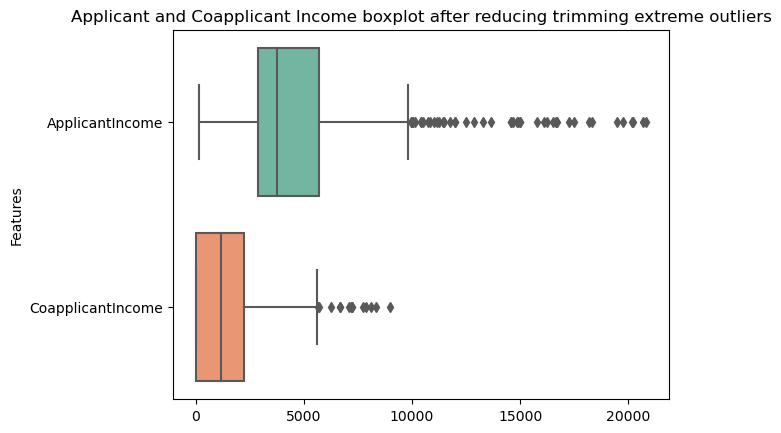

In [48]:
sns.boxplot(data=data[['ApplicantIncome','CoapplicantIncome']],orient='h',palette='Set2')
plt.ylabel("Features")
plt.title("Applicant and Coapplicant Income boxplot after reducing trimming extreme outliers")
plt.show()

**INTERPRATION:**
* The previous box plot showed the extreme outliers that reached even above 80000 on applicant income feature and above 40000 on coapplicant income. 
* The present box plot showed the distribution of data after removing extreme outliers above 25000 on applicant income feature and 10000 on coapplicant income.

## 3. Multivariate Analysis

### a. Multivariate Regression (Modelling)

**dependent and independent features**

In [49]:
X = data.drop(['Loan_ID','Gender', 'Married', 'Dependents',
       'Education', 'Self_Employed','Credit_History', 'Property_Area',
       'Loan_Status','Loan_Status_encoded','Loan_ID_encoded'],axis=1)
y = data['Loan_Status_encoded']

**Train and test data**

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.2,random_state=42)

**helper function for training, predicting and then find the score**

In [51]:
def findModelPerfomance(model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_pred,y_test)
  print("Accuracy:", accuracy)

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

**model 1 - Random Forest**

In [52]:
# a Random Forest classifier with 100 trees
clf = RandomForestClassifier(n_estimators=100)
findModelPerfomance(clf)

Accuracy: 0.7625
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.46      0.54       148
         1.0       0.79      0.90      0.84       332

    accuracy                           0.76       480
   macro avg       0.73      0.68      0.69       480
weighted avg       0.75      0.76      0.75       480

Confusion Matrix:
[[ 68  80]
 [ 34 298]]


**model 2 - (L2 Regularization) Ridge classifier**

In [53]:
ridge = RidgeClassifierCV()
findModelPerfomance(ridge)

Accuracy: 0.7916666666666666
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.46      0.58       148
         1.0       0.80      0.94      0.86       332

    accuracy                           0.79       480
   macro avg       0.78      0.70      0.72       480
weighted avg       0.79      0.79      0.77       480

Confusion Matrix:
[[ 68  80]
 [ 20 312]]


**model 3 - Logistic Regression with L1(lasso) Regularization**

In [54]:
# Logistic Regression classifier with L1 (Lasso) regularization
logistic = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
findModelPerfomance(logistic)

Accuracy: 0.7875
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.46      0.57       148
         1.0       0.79      0.93      0.86       332

    accuracy                           0.79       480
   macro avg       0.78      0.70      0.72       480
weighted avg       0.78      0.79      0.77       480

Confusion Matrix:
[[ 68  80]
 [ 22 310]]


**model 4 - Logistic Regression with L1(lasso) and L2(ridge) Regularization**

In [55]:
# Logistic Regression classifier with Elastic Net regularization
elasticnet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0)
findModelPerfomance(elasticnet)

Accuracy: 0.6916666666666667
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       148
         1.0       0.69      1.00      0.82       332

    accuracy                           0.69       480
   macro avg       0.35      0.50      0.41       480
weighted avg       0.48      0.69      0.57       480

Confusion Matrix:
[[  0 148]
 [  0 332]]


**Model 5 - Decision tree**

In [56]:
tree = DecisionTreeClassifier(max_depth=5)
findModelPerfomance(tree)

Accuracy: 0.7645833333333333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.45      0.54       148
         1.0       0.79      0.91      0.84       332

    accuracy                           0.76       480
   macro avg       0.73      0.68      0.69       480
weighted avg       0.75      0.76      0.75       480

Confusion Matrix:
[[ 66  82]
 [ 31 301]]


**INTERPRETATION ON MODELS:**

it's evident that Model 2, the Ridge Classifier with L2 Regularization, stands out with an accuracy of 79.17%. This model demonstrates a balanced performance, effectively identifying both positive and negative instances. With a precision of 80% and recall of 94% for the positive class, it strikes a good balance between correctly identifying actual positive instances and minimizing false negatives. The F1-score of 0.86 indicates a robust balance between precision and recall. Additionally, the confusion matrix shows a lower number of false negatives compared to other models, highlighting its effectiveness in identifying actual positive cases.


In summary, Model 2, the Ridge Classifier with L2 Regularization, is recommended due to its strong overall performance, achieving a high accuracy and demonstrating a well-balanced trade-off between precision and recall in identifying loan defaults.


## COMMUNICATE THE RESULT

In [57]:
#### Model with high accuracy is Ridge
# Access coefficients
coefficients = ridge.coef_

feature_name = ['Applicant Income', 'Coapplicant Income', 'Loan Amount',
       'Loan Amount Term',
       'Gender', 'Married', 'Dependents',
       'Education', 'Self Employed',  'Credit History','Property Area']

# Print coefficients for each feature
for feature, coef in zip(feature_name, coefficients[0]):
    print(f"{feature} have a weight = {coef}")

Applicant Income have a weight = 2.7910050073471295e-06
Coapplicant Income have a weight = 7.79430548836578e-05
Loan Amount have a weight = -0.0017004001404948429
Loan Amount Term have a weight = -0.0007878260875066337
Gender have a weight = 0.03643278477007046
Married have a weight = 0.020270221908842624
Dependents have a weight = -0.04576195923305505
Education have a weight = 0.4153380700760061
Self Employed have a weight = 0.17214107665554101
Credit History have a weight = 1.3171045587433616
Property Area have a weight = 0.23227424141081002


**Standardize coefficients**

When the coefficients with varying magnitudes, it can be challenging to visualize them on a bar chart directly because the smaller coefficients might not be visible compared to the larger ones. Therefore, let's standardize the coefficients before plotting. This allows to compare the relative importance of features, regardless of their original scale.

In [58]:
# Standardize coefficients
scaler = StandardScaler()
coefficients_standardized = scaler.fit_transform(coefficients.reshape(-1, 1)).flatten()

In [59]:
coefficients_standardized = np.round(coefficients_standardized, 2)

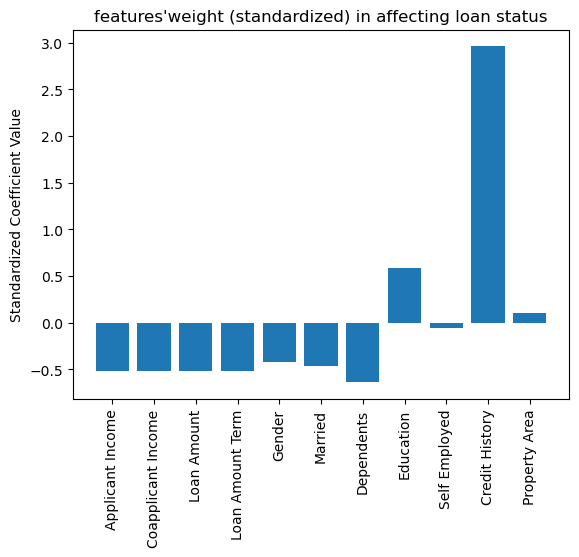

In [60]:
# Visualize standardized coefficients
fig, ax = plt.subplots()
ax.bar(range(len(coefficients_standardized)), coefficients_standardized)
ax.set_xticks(range(len(coefficients_standardized)))
ax.set_xticklabels(feature_name, rotation=90)
ax.set_ylabel('Standardized Coefficient Value')
ax.set_title("features'weight (standardized) in affecting loan status")
plt.show()

In [61]:
feature_importance=dict()

In [62]:
for name,importance in zip(feature_name,coefficients_standardized):
    feature_importance[name]=importance

In [63]:
loanApproval_dict_data['standardized feature importance'] = feature_importance

**saving the cleaned data**

In [64]:

# Specify the file path where you want to save the JSON data
file_path = './Loan Approval Prediction/data.json'

# Save the dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(loanApproval_dict_data, json_file)

print(f'Dictionary saved to {file_path}')


Dictionary saved to ./Loan Approval Prediction/data.json
